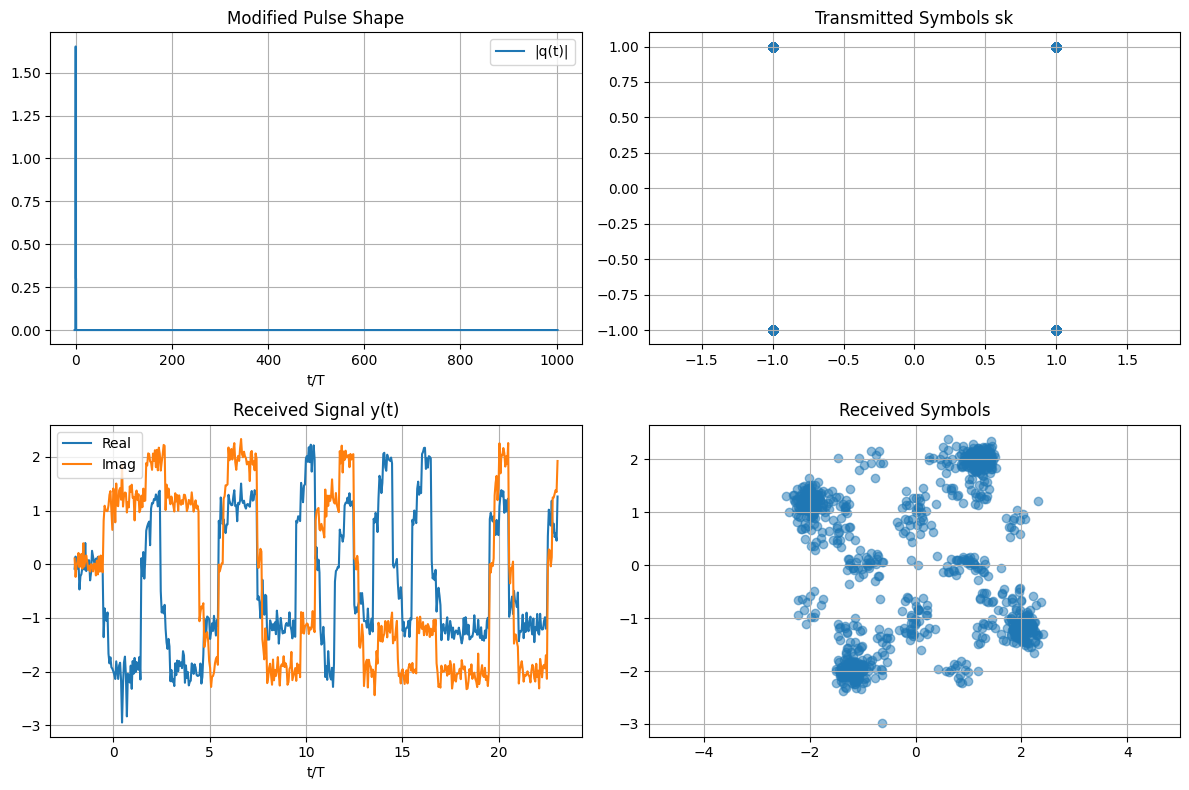

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def pulse(t, T):
    """Rectangular pulse p(t)"""
    return np.where(np.abs(t) <= T/2, 1, 0)

def channel_response(t, delays, gains, wc):
    """Channel response Σ aᵢexp[j(ωc τᵢ)]"""
    h = np.zeros(len(t), dtype=complex)
    for delay, gain in zip(delays, gains):
        h += gain * np.exp(1j * wc * delay)
    return h

def modified_pulse(t, T, delays, gains, wc):
    """Modified pulse q(t) = Σ aᵢexp[j(ωc τᵢ)]p(t-τᵢ)"""
    q = np.zeros(len(t), dtype=complex)
    for delay, gain in zip(delays, gains):
        shifted_t = t - delay
        q += gain * np.exp(1j * wc * delay) * pulse(shifted_t, T)
    return q

# Parameters
T = 1  # Symbol period
n_symbols = 1000
t = np.linspace(-2*T, (n_symbols+2)*T, n_symbols*20)
wc = 2*np.pi*0.25  # Carrier frequency

# Channel parameters
delays = [0, T/4, T/2]
gains = [1, 0.5*np.exp(1j*np.pi/6), 0.3*np.exp(-1j*np.pi/4)]

# Generate QAM symbols (sk)
symbols = (np.random.randint(0, 2, n_symbols)*2 - 1) + 1j*(np.random.randint(0, 2, n_symbols)*2 - 1)

# Generate transmitted signal Σ sk p(t-kT)
tx_signal = np.zeros(len(t), dtype=complex)
for k, sk in enumerate(symbols):
    tx_signal += sk * pulse(t - k*T, T)

# Generate received signal Σ sk q(t-kT) + n(t)
rx_signal = np.zeros(len(t), dtype=complex)
q = modified_pulse(t, T, delays, gains, wc)
for k, sk in enumerate(symbols):
    rx_signal += sk * np.roll(q, int(k*T*len(t)/t[-1]))

# Add noise
snr_db = 20
noise_power = np.mean(np.abs(rx_signal)**2) / (10**(snr_db/10))
noise = np.sqrt(noise_power/2) * (np.random.randn(len(t)) + 1j*np.random.randn(len(t)))
rx_signal += noise

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.plot(t/T, np.abs(q), label='|q(t)|')
plt.title('Modified Pulse Shape')
plt.xlabel('t/T')
plt.grid(True)
plt.legend()

plt.subplot(222)
plt.scatter(symbols.real, symbols.imag, alpha=0.5)
plt.title('Transmitted Symbols sk')
plt.grid(True)
plt.axis('equal')

plt.subplot(223)
plt.plot(t[:500]/T, rx_signal[:500].real, label='Real')
plt.plot(t[:500]/T, rx_signal[:500].imag, label='Imag')
plt.title('Received Signal y(t)')
plt.xlabel('t/T')
plt.grid(True)
plt.legend()

# Sample received signal at symbol rate
sample_points = np.arange(n_symbols) * len(t)//n_symbols
rx_symbols = rx_signal[sample_points]

plt.subplot(224)
plt.scatter(rx_symbols.real, rx_symbols.imag, alpha=0.5)
plt.title('Received Symbols')
plt.grid(True)
plt.axis('equal')

plt.tight_layout()
plt.show()